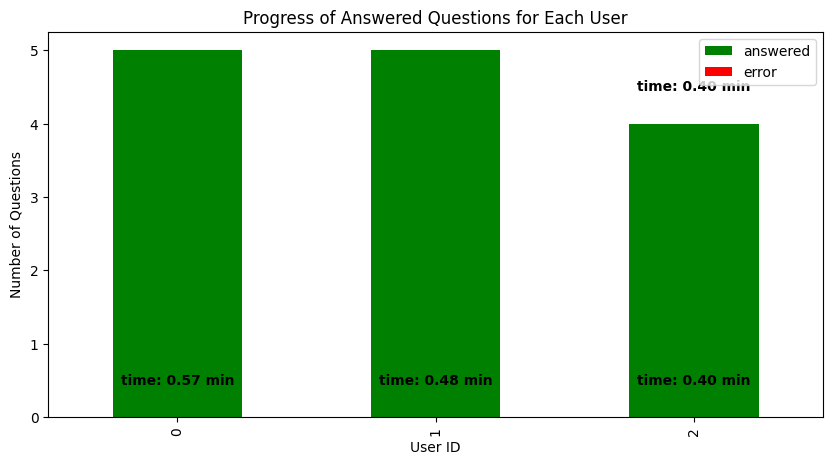

In [3]:
import os
import tempfile
import pandas as pd
import random
import boto3
from langchain_community.llms import Bedrock
from langchain_aws import BedrockLLM
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
import time
import certifi
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from IPython.display import display, clear_output
from threading import Lock

# Set the AWS profile and certificate bundle
os.environ["AWS_PROFILE"] = "default"
os.environ["REQUESTS_CA_BUNDLE"] = certifi.where()

# Set the model ID
model_id = "meta.llama3-8b-instruct-v1:0"

# Create a temporary directory for storing the uploaded files
temp_dir = tempfile.TemporaryDirectory()

def validate_file(file_path):
    """
    Validates the uploaded file to ensure it can be read as an Excel file.
    
    Parameters:
    - file_path: str, path to the file to be validated
    
    Returns:
    - Tuple (bool, int): True if the file is valid, and the number of rows in the file
    """
    try:
        df = pd.read_excel(file_path)
        return True, df.shape[0]
    except Exception as e:
        return False, 0

def initialize_bedrock_client():
    """
    Initializes the Bedrock client.
    
    Returns:
    - bedrock_client: boto3 client, initialized Bedrock client
    """
    return boto3.client(
        service_name="bedrock-runtime",
        region_name="us-east-1"
    )

def chat(question):
    """
    Sends a question to the Bedrock LLM and returns the response.
    
    Parameters:
    - question: str, the question to be sent
    
    Returns:
    - response: dict, the response from the LLM
    """
    prompt = PromptTemplate(
        input_variables=["question"],
        template="{question}"
    )

    bedrock_chain = LLMChain(llm=llm, prompt=prompt)
    response = bedrock_chain({'question': question})
    return response

def simulate_user_questions(user_id, questions, user_progress, user_time, lock):
    """
    Simulates a user asking questions and updates the progress.
    
    Parameters:
    - user_id: int, ID of the user
    - questions: list, list of questions to ask
    - user_progress: dict, dictionary to store user progress
    - user_time: dict, dictionary to store time taken by the user
    - lock: threading.Lock, lock to synchronize access to shared resources
    """
    random.shuffle(questions)
    for question in questions:
        try:
            start_time = time.time()
            response = chat(question)
            answer = response["text"]
            end_time = time.time()
            time_taken = end_time - start_time
            user_time[user_id] += time_taken
            user_progress[user_id]["answered"] += 1
        except Exception as e:
            error_info = f"Error occurred for user {user_id} question: {question}. Error: {str(e)}"
            error_log.append(error_info)
            user_progress[user_id]["error"] += 1

        with lock:
            update_plot(user_progress, user_time)

def update_plot(user_progress, user_time):
    """
    Updates the plot showing the progress of users.
    
    Parameters:
    - user_progress: dict, dictionary containing progress of users
    - user_time: dict, dictionary containing time taken by users
    """
    progress_df = pd.DataFrame(user_progress).T
    fig, ax = plt.subplots(figsize=(10, 5))
    progress_df.plot(kind='bar', stacked=True, color=['green', 'red'], ax=ax)
    ax.set_xlabel('User ID')
    ax.set_ylabel('Number of Questions')
    ax.set_title('Progress of Answered Questions for Each User')
    ax.yaxis.get_major_locator().set_params(integer=True)

    for p in ax.patches:
        user_id = int(p.get_x() + p.get_width() / 2)
        time_text = f"time: {user_time[user_id] / 60:.2f} min"
        ax.annotate(time_text, (p.get_x() + p.get_width() / 2, p.get_height() + 0.5), 
                    ha='center', va='center', fontsize=10, color='black', fontweight='bold')

    clear_output(wait=True)
    display(fig)
    plt.close(fig)

# Placeholder for user input file paths
users_file_path = "users.xlsx"  # Replace with the actual path
questions_file_path = "questions.xlsx"  # Replace with the actual path

# Validate the files
is_users_valid, user_count = validate_file(users_file_path)
is_questions_valid, question_count = validate_file(questions_file_path)

error_log = []

if is_users_valid and is_questions_valid:
    users = pd.read_excel(users_file_path)
    questions_df = pd.read_excel(questions_file_path)

    if 'Question' not in questions_df.columns:
        print("Error: The 'Question' column is not found in the questions file.")
        print(f"Available columns are: {questions_df.columns.tolist()}")
    else:
        questions = questions_df["Question"].tolist()

        user_progress = {user_id: {"answered": 0, "error": 0} for user_id in users.index}
        user_time = {user_id: 0 for user_id in users.index}
        lock = Lock()

        bedrock_client = initialize_bedrock_client()

        llm = BedrockLLM(
            model_id=model_id,
            client=bedrock_client,
            model_kwargs={"max_gen_len": 512, "temperature": 0.5}
        )

        with ThreadPoolExecutor(max_workers=user_count) as executor:
            futures = []
            for user_id in users.index:
                futures.append(executor.submit(simulate_user_questions, user_id, questions, user_progress, user_time, lock))
                time.sleep(5)

            for future in as_completed(futures):
                future.result()

        print(f"Volume testing completed with {user_count} users and {question_count} questions.")
        if error_log:
            print("Errors occurred during volume testing. Here are the details:")
            for error in error_log:
                print(error)
else:
    print("One or both of the uploaded files are not valid Excel files.")


